In [33]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, Flatten, Lambda, BatchNormalization, Conv1D
from tensorflow.keras.layers import Reshape, Conv2DTranspose, UpSampling2D
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import mnist
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

import random as rn
import numpy as np
import easydict
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile

import sounddevice as sd

import pandas as pd
import tensorflow as tf
import glob
import pydot

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

import IPython.display as ipd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import style
import seaborn as sns

%matplotlib inline
sns.set(style='whitegrid', color_codes=True)

In [34]:
seed = 100
np.random.seed(seed)
rn.seed(seed)
tf.set_random_seed(seed)

In [35]:
labels = pd.read_csv('train_labels.csv')
sample_solution = pd.read_csv('sample_submission.csv')
train = np.load('train_data.npy')
test = np.load('test_data.npy')

labels = labels.drop('Id', 1)

In [36]:
Y = to_categorical(labels, 2)
x_train, x_test, y_train, y_test = train_test_split(
    train, Y, test_size=0.1, random_state=seed)

print("TRAIN SHAPE")
print(x_train.shape)
print("TEST SHAPE")
print(x_test.shape)


image_size = x_train.shape[1]

TRAIN SHAPE
(3599, 44100)
TEST SHAPE
(400, 44100)


In [37]:
batch_size = 61
dense_z = 2
epoch = 10

In [38]:
# encoder
inputs = Input(shape=(44100,))
hidden_q = Dense(16, activation='relu')(inputs)
u = Dense(dense_z, activation='linear')(hidden_q)
log_sigma = Dense(dense_z, activation='linear')(hidden_q)

In [39]:
def sample_z(args):
    u, log_sigma = args
    eps = K.random_normal(shape=(m, dense_z), mean=0., stddev=1.)
    return u + K.exp(log_sigma / 2) * eps


z = Lambda(sample_z)([u, log_sigma])

In [40]:
# decoder
decoder_hidden = Dense(128, activation='relu')
decoder_out = Dense(44100, activation='sigmoid')

hidden_p = decoder_hidden(z)
outputs = decoder_out(hidden_p)

In [41]:
vae = Model(inputs, outputs)

vae.summary()

encoder = Model(inputs, u)

# generator model, uses latent variable
d_in = Input(shape=(dense_z,))
d_h = decoder_hidden(d_in)
d_out = decoder_out(d_h)
decoder = Model(d_in, d_out)

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 44100)]      0                                            
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 16)           705616      input_6[0][0]                    
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 2)            34          dense_12[0][0]                   
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 2)            34          dense_12[0][0]                   
____________________________________________________________________________________________

In [42]:
def vae_loss(y_true, y_pred):
    print('y_true', y_true)
    print('y_pred', y_pred)
    # calculate loss
    r = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
    print(r)
    kl = 0.5 * K.sum(K.exp(log_sigma) + K.square(u) - 1. - log_sigma, axis=1)
    print(kl)

    return r + kl

In [43]:
vae.compile(optimizer='adam', loss=vae_loss)
vae.fit(x_train, x_train, batch_size=m, epochs=n_epoch)

y_true Tensor("dense_16_target:0", shape=(?, ?), dtype=float32)
y_pred Tensor("dense_16/Sigmoid:0", shape=(61, 44100), dtype=float32)
Tensor("loss_4/dense_16_loss/Sum:0", shape=(61,), dtype=float32)
Tensor("loss_4/dense_16_loss/mul_2:0", shape=(?,), dtype=float32)
Epoch 1/10
3599/3599 [==============================] - 2s 424us/sample - loss: 1080895128601293.7500
Epoch 2/10
3599/3599 [==============================] - 1s 295us/sample - loss: nan
Epoch 3/10
3599/3599 [==============================] - 1s 302us/sample - loss: nan
Epoch 4/10
3599/3599 [==============================] - 1s 294us/sample - loss: nan
Epoch 5/10
3599/3599 [==============================] - 1s 295us/sample - loss: nan
Epoch 6/10
3599/3599 [==============================] - 1s 298us/sample - loss: nan
Epoch 7/10
3599/3599 [==============================] - 1s 295us/sample - loss: nan
Epoch 8/10
3599/3599 [==============================] - 1s 297us/sample - loss: nan
Epoch 9/10
3599/3599 [=======================

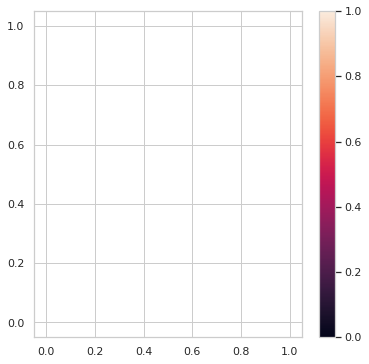

In [45]:
x_test_encoded = encoder.predict(x_test, batch_size=m)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1])
plt.colorbar()
plt.show()